# Data Preprocessing – Music Genre Classification

Mục tiêu của notebook này:

1. Xây dựng pipeline tiền xử lý dữ liệu cho bài toán Music Genre Classification:
   - Xử lý missing values.
   - Feature Engineering theo artist/track.
   - Feature Engineering numeric (log, interaction, ratio, cyclical).
   - Target Encoding (CV) cho `Artist Name`.
   - Thêm đặc trưng clustering và PCA.
2. Tạo ra hai phiên bản dataset:
   - **Exp1**: baseline sạch, gần với dữ liệu gốc.
   - **Exp2**: phiên bản đã Feature Engineering đầy đủ.
3. Xuất ra:
   - `train_exp1.csv`, `test_exp1.csv`
   - `train_exp2.csv`, `test_exp2.csv`
   - `feature_metadata.json` mô tả feature của từng Exp.


In [1]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# PATH: đọc dữ liệu từ Kaggle Input
DATA_RAW_DIR = "../data/raw"

# PATH: lưu file output tại Kaggle Working
DATA_PROC_DIR = "../data"

# tạo folder exp1 & exp2 
os.makedirs(os.path.join(DATA_PROC_DIR, "exp1"), exist_ok=True)
os.makedirs(os.path.join(DATA_PROC_DIR, "exp2"), exist_ok=True)

# đọc file raw
train_raw = pd.read_csv(f"{DATA_RAW_DIR}/train (1).csv")
test_raw  = pd.read_csv(f"{DATA_RAW_DIR}/test (2).csv")

print("Train raw shape:", train_raw.shape)
print("Test raw shape :", test_raw.shape)
train_raw.head()


Train raw shape: (14396, 18)
Test raw shape : (3600, 17)


,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,1,Marina Maximilian,Not Afraid,37.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,NaN,0.106,0.235,152.429,204947.0,4,9
1,2,The Black Keys,Howlin' for You,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.0468,0.104,0.380,132.921,191956.0,4,6
2,3,Royal & the Serpent,phuck u,NaN,0.584,0.804,7.0,-6.094,1,0.0619,0.000968,0.6350,0.284,0.635,159.953,161037.0,4,10
3,4,Detroit Blues Band,Missing You,12.0,0.515,0.308,NaN,-14.711,1,0.0312,0.907000,0.0213,0.300,0.501,172.472,298093.0,3,2
4,5,Coast Contra,My Lady,48.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,NaN,0.211,0.619,88.311,254145.0,4,5


## 1. Xử lý Missing Values

Dựa trên EDA:

- `Popularity` có một lượng nhỏ missing và phân phối lệch → dùng **median**.
- `key` là biến phân loại (0–11) → dùng **mode**.
- `instrumentalness` thiếu khá nhiều → dùng **median** để ổn định.

Hàm `impute_missing()` áp dụng chiến lược trên cho cả train và test.


In [2]:
def impute_missing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Xử lý giá trị thiếu:
    - Popularity: median
    - key: mode
    - instrumentalness: median
    """
    df = df.copy()
    
    if "Popularity" in df.columns:
        df["Popularity"] = df["Popularity"].fillna(df["Popularity"].median())
    
    if "key" in df.columns:
        key_mode = df["key"].mode(dropna=True)
        key_mode = key_mode.iloc[0] if len(key_mode) > 0 else 0
        df["key"] = df["key"].fillna(key_mode)
    
    if "instrumentalness" in df.columns:
        df["instrumentalness"] = df["instrumentalness"].fillna(df["instrumentalness"].median())
    
    return df


## 2. Đặc trưng theo `Artist Name` và `Track Name`

Insight từ EDA:

- Mỗi artist thường gắn với một số thể loại âm nhạc nhất định.
- Một track có thể xuất hiện nhiều lần.

Ta tạo các đặc trưng thống kê:

- `artist_track_count`: số bài hát của mỗi artist.
- `artist_mean_pop`: trung bình `Popularity` của mỗi artist.
- `track_count`: số lần xuất hiện mỗi track.

Các thống kê tính từ **train**, sau đó join sang test; các artist/track chỉ xuất hiện ở test được fill bằng median.


In [3]:
def add_artist_track_stats(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Thêm đặc trưng thống kê theo Artist Name & Track Name:
    - artist_track_count
    - artist_mean_pop
    - track_count
    """
    train_df = train_df.copy()
    test_df  = test_df.copy()
    
    artist_stats = train_df.groupby("Artist Name").agg(
        artist_track_count=("Id", "count"),
        artist_mean_pop=("Popularity", "mean")
    )

    track_stats = train_df.groupby("Track Name").agg(
        track_count=("Id", "count")
    )
    
    # Join
    train_df = train_df.join(artist_stats, on="Artist Name")
    train_df = train_df.join(track_stats, on="Track Name")
    
    test_df = test_df.join(artist_stats, on="Artist Name")
    test_df = test_df.join(track_stats, on="Track Name")
    
    # Fill missing thống kê (artist/track chỉ xuất hiện trong test)
    for col in ["artist_track_count", "artist_mean_pop", "track_count"]:
        med = train_df[col].median()
        train_df[col] = train_df[col].fillna(med)
        test_df[col]  = test_df[col].fillna(med)
    
    return train_df, test_df


## 3. Đặc trưng numeric cơ bản

Các bước:

- Đổi tên `duration_in min/ms` → `duration_ms` và tạo thêm `duration_min`.
- Thêm log-transform:
  - `tempo_log = log1p(tempo)`
  - `popularity_log = log1p(Popularity)`
- Mã hóa chu kỳ cho `key`:
  - `key_sin`, `key_cos`
- Tạo đặc trưng kết hợp cường độ:
  - `energy_loudness = energy * (-loudness)`


In [4]:
def add_numeric_fe_basic(df: pd.DataFrame) -> pd.DataFrame:
    """
    FE numeric cơ bản:
    - duration_ms + duration_min
    - tempo_log, popularity_log
    - key_sin, key_cos
    - energy_loudness
    """
    df = df.copy()
    
    # duration_ms
    if "duration_in min/ms" in df.columns:
        df = df.rename(columns={"duration_in min/ms": "duration_ms"})
    
    if "duration_ms" in df.columns:
        df["duration_min"] = df["duration_ms"] / 60000.0
    
    # log transform
    if "tempo" in df.columns:
        df["tempo_log"] = np.log1p(df["tempo"])
    if "Popularity" in df.columns:
        df["popularity_log"] = np.log1p(df["Popularity"])
    
    # cyclical key
    if "key" in df.columns:
        df["key_sin"] = np.sin(2 * np.pi * df["key"] / 12.0)
        df["key_cos"] = np.cos(2 * np.pi * df["key"] / 12.0)
    
    # energy_loudness
    if "energy" in df.columns and "loudness" in df.columns:
        df["energy_loudness"] = df["energy"] * (-df["loudness"])
    
    return df


## 4. Đặc trưng numeric nâng cao (ratio / interaction)

Để mô tả tính chất âm nhạc rõ hơn, ta thêm một số đặc trưng tỉ lệ/kết hợp:

- `energy_acoustic_ratio = energy / (acousticness + eps)`  
  → nhạc càng điện tử thì tỷ lệ này càng cao.
- `dance_energy = danceability * energy`  
  → mức độ “dance” tổng hợp.
- `valence_energy = valence * energy`  
  → nhạc vừa vui (valence) vừa mạnh (energy).
- `instr_acoustic = instrumentalness * acousticness`  
  → nhạc instrumental + acoustic.

Các đặc trưng này dựa trên hiểu biết về audio nên thường giúp mô hình phân biệt tốt hơn.


In [5]:
def add_numeric_fe_advanced(df: pd.DataFrame) -> pd.DataFrame:
    """
    FE numeric nâng cao: ratio & interaction
    """
    df = df.copy()
    eps = 1e-3
    
    if {"energy", "acousticness"}.issubset(df.columns):
        df["energy_acoustic_ratio"] = df["energy"] / (df["acousticness"] + eps)
    
    if {"danceability", "energy"}.issubset(df.columns):
        df["dance_energy"] = df["danceability"] * df["energy"]
    
    if {"valence", "energy"}.issubset(df.columns):
        df["valence_energy"] = df["valence"] * df["energy"]
    
    if {"instrumentalness", "acousticness"}.issubset(df.columns):
        df["instr_acoustic"] = df["instrumentalness"] * df["acousticness"]
    
    return df


## 5. Target Encoding cho `Artist Name` (K-fold, tránh leakage)

`Artist Name` là biến dạng text với rất nhiều giá trị khác nhau.

Thay vì one-hot, ta mã hóa artist bằng **target encoding**:

- Với mỗi artist, tính giá trị trung bình của target (`Class`).
- Để tránh overfit và leakage, dùng **StratifiedKFold**:
  - Mỗi fold:
    - Tính mean trên phần train của fold.
    - Áp dụng cho phần valid (out-of-fold).
- Với test:
  - Dùng mean tính trên toàn bộ train.
  - Artist mới trong test → dùng global mean.

Thêm smoothing để artist ít mẫu không quá cực đoan.


In [6]:
def target_encode_cv(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    col: str,
    target_col: str = "Class",
    n_splits: int = 5,
    smoothing: float = 20.0,
    random_state: int = 42
):
    """
    Target encoding cho cột 'col' dùng K-fold out-of-fold.
    Trả về train_df, test_df với cột mới: f"{col}_te".
    """
    train_df = train_df.copy()
    test_df  = test_df.copy()
    
    global_mean = train_df[target_col].mean()
    te_train = np.zeros(len(train_df))
    
    kf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )
    
    for tr_idx, val_idx in kf.split(train_df, train_df[target_col]):
        X_tr, X_val = train_df.iloc[tr_idx], train_df.iloc[val_idx]
        
        stats = X_tr.groupby(col)[target_col].agg(["mean", "count"])
        smoothing_factor = stats["count"] / (stats["count"] + smoothing)
        stats["te"] = stats["mean"] * smoothing_factor + global_mean * (1 - smoothing_factor)
        
        te_val = X_val[col].map(stats["te"]).fillna(global_mean)
        te_train[val_idx] = te_val.values
    
    new_col = f"{col}_te"
    train_df[new_col] = te_train
    
    # Áp dụng cho test
    full_stats = train_df.groupby(col)[target_col].agg(["mean", "count"])
    smoothing_factor = full_stats["count"] / (full_stats["count"] + smoothing)
    full_stats["te"] = full_stats["mean"] * smoothing_factor + global_mean * (1 - smoothing_factor)
    
    te_test = test_df[col].map(full_stats["te"]).fillna(global_mean)
    test_df[new_col] = te_test.values
    
    return train_df, test_df, new_col


## 6. Thêm đặc trưng Clustering và PCA

Để nắm bắt cấu trúc tổng thể trong không gian đặc trưng:

- Chuẩn hoá các feature numeric.
- Dùng **KMeans** để phân cụm → tạo thêm cột `cluster_id`.
- Dùng **PCA** với 2 thành phần đầu → tạo thêm `pc1`, `pc2`.

Các feature này giúp mô hình nhận biết vị trí tương đối của bài hát trong "không gian âm thanh".


In [7]:
def add_cluster_pca_features(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    numeric_cols: list,
    n_clusters: int = 12,
    random_state: int = 42
):
    """
    Thêm:
    - cluster_id (KMeans)
    - pc1, pc2 (PCA 2D)
    """
    train_df = train_df.copy()
    test_df  = test_df.copy()
    
    X_train = train_df[numeric_cols].fillna(train_df[numeric_cols].median())
    X_test  = test_df[numeric_cols].fillna(train_df[numeric_cols].median())
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    train_df["cluster_id"] = kmeans.fit_predict(X_train_scaled)
    test_df["cluster_id"]  = kmeans.predict(X_test_scaled)
    
    # PCA
    pca = PCA(n_components=2, random_state=random_state)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca  = pca.transform(X_test_scaled)
    
    train_df["pc1"] = X_train_pca[:, 0]
    train_df["pc2"] = X_train_pca[:, 1]
    test_df["pc1"]  = X_test_pca[:, 0]
    test_df["pc2"]  = X_test_pca[:, 1]
    
    return train_df, test_df


## 7. Xây dựng Exp1 – Baseline sạch

Exp1:

- Impute missing theo chiến lược chung.
- Không làm Target Encoding, Clustering, PCA.
- Bỏ `Artist Name`, `Track Name` để dữ liệu hoàn toàn numeric.
- Đổi tên `duration_in min/ms` → `duration_ms`.

Exp1 dùng để xây các mô hình baseline và so sánh với Exp2.


In [8]:
def build_exp1_datasets(train_raw: pd.DataFrame, test_raw: pd.DataFrame):
    train = impute_missing(train_raw)
    test  = impute_missing(test_raw)
    
    drop_cols = ["Artist Name", "Track Name"]
    train = train.drop(columns=drop_cols)
    test  = test.drop(columns=drop_cols)
    
    if "duration_in min/ms" in train.columns:
        train = train.rename(columns={"duration_in min/ms": "duration_ms"})
    if "duration_in min/ms" in test.columns:
        test = test.rename(columns={"duration_in min/ms": "duration_ms"})
    
    return train, test

train_exp1, test_exp1 = build_exp1_datasets(train_raw, test_raw)
print("train_exp1 shape:", train_exp1.shape)
print("test_exp1 shape :", test_exp1.shape)
train_exp1.head()


train_exp1 shape: (14396, 16)
test_exp1 shape : (3600, 15)


,Id,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Class
0,1,37.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,0.00392,0.106,0.235,152.429,204947.0,4,9
1,2,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.04680,0.104,0.380,132.921,191956.0,4,6
2,3,44.0,0.584,0.804,7.0,-6.094,1,0.0619,0.000968,0.63500,0.284,0.635,159.953,161037.0,4,10
3,4,12.0,0.515,0.308,7.0,-14.711,1,0.0312,0.907000,0.02130,0.300,0.501,172.472,298093.0,3,2
4,5,48.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,0.00392,0.211,0.619,88.311,254145.0,4,5


## 8. Xây dựng Exp2 – Dataset đã Feature Engineering đầy đủ

Pipeline Exp2:

1. Impute missing.
2. Thêm thống kê theo artist & track.
3. Thêm FE numeric cơ bản.
4. Thêm FE numeric nâng cao (ratio/interaction).
5. Target encoding cho `Artist Name`.
6. Thêm `cluster_id`, `pc1`, `pc2` từ KMeans + PCA.
7. Bỏ `Artist Name` và `Track Name` (dạng text) để còn lại toàn bộ đặc trưng numeric.

Exp2 là dataset chính để huấn luyện các mô hình mạnh hơn (XGBoost, LightGBM, v.v.).


In [9]:
def build_exp2_datasets(train_raw: pd.DataFrame, test_raw: pd.DataFrame):
    # 1. Impute
    train = impute_missing(train_raw)
    test  = impute_missing(test_raw)
    
    # 2. Artist/Track stats
    train, test = add_artist_track_stats(train, test)
    
    # 3. Numeric FE cơ bản
    train = add_numeric_fe_basic(train)
    test  = add_numeric_fe_basic(test)
    
    # 4. Numeric FE nâng cao
    train = add_numeric_fe_advanced(train)
    test  = add_numeric_fe_advanced(test)
    
    # 5. Target Encoding cho Artist Name
    train, test, _ = target_encode_cv(
        train_df=train,
        test_df=test,
        col="Artist Name",
        target_col="Class",
        n_splits=5,
        smoothing=20.0,
        random_state=42
    )
    
    # 6. Cluster + PCA: dùng tất cả cột numeric (trừ Id & Class)
    numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in ["Id", "Class"]]
    
    train, test = add_cluster_pca_features(
        train_df=train,
        test_df=test,
        numeric_cols=numeric_cols,
        n_clusters=12,
        random_state=42
    )
    
    # 7. Bỏ cột text
    drop_text_cols = ["Artist Name", "Track Name"]
    train = train.drop(columns=drop_text_cols)
    test  = test.drop(columns=drop_text_cols)
    
    return train, test

train_exp2, test_exp2 = build_exp2_datasets(train_raw, test_raw)
print("train_exp2 shape:", train_exp2.shape)
print("test_exp2 shape :", test_exp2.shape)
train_exp2.head()


train_exp2 shape: (14396, 33)
test_exp2 shape : (3600, 32)


,Id,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,key_cos,energy_loudness,energy_acoustic_ratio,dance_energy,valence_energy,instr_acoustic,Artist Name_te,cluster_id,pc1,pc2
0,1,37.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,0.00392,...,-1.836970e-16,3.563864,1.414248,0.179024,0.125960,0.001482,7.156543,2,-1.281052,-1.213184
1,2,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.04680,...,8.660254e-01,4.142115,26.489362,0.541575,0.283860,0.001273,6.203341,10,1.621958,1.821230
2,3,44.0,0.584,0.804,7.0,-6.094,1,0.0619,0.000968,0.63500,...,-8.660254e-01,4.899576,408.536585,0.469536,0.510540,0.000615,6.805409,2,1.580332,-0.396755
3,4,12.0,0.515,0.308,7.0,-14.711,1,0.0312,0.907000,0.02130,...,-8.660254e-01,4.530988,0.339207,0.158620,0.154308,0.019319,6.695679,11,-3.180269,-3.163727
4,5,48.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,0.00392,...,-1.000000e+00,3.959592,4.222826,0.439005,0.480963,0.000717,6.695679,8,1.093195,0.455767


## 9. Xuất file CSV & metadata

Cuối cùng, ta lưu:

- Dataset Exp1:
  - `train_exp1.csv`
  - `test_exp1.csv`
- Dataset Exp2:
  - `train_exp2.csv`
  - `test_exp2.csv`

Đồng thời ghi file `feature_metadata.json` để:

- Lưu shape của từng dataset.
- Lưu danh sách feature (trừ `Id`, `Class`) của mỗi Exp – hỗ trợ cho các notebook modeling.


In [10]:
exp1_dir = os.path.join(DATA_PROC_DIR, "exp1")
exp2_dir = os.path.join(DATA_PROC_DIR, "exp2")

# SAVE EXP1
train_exp1.to_csv("../data/exp1/train_exp1.csv", index=False)
test_exp1.to_csv("../data/exp1/test_exp1.csv", index=False)

# SAVE EXP2
train_exp2.to_csv("../data/exp2/train_exp2.csv", index=False)
test_exp2.to_csv("../data/exp2/test_exp2.csv", index=False)

print("Saved CSV files:")
print(f"- {exp1_dir}/train_exp1.csv")
print(f"- {exp1_dir}/test_exp1.csv")
print(f"- {exp2_dir}/train_exp2.csv")
print(f"- {exp2_dir}/test_exp2.csv")

# SAVE METADATA
import json

meta = {
    "exp1": {
        "train_shape": train_exp1.shape,
        "test_shape": test_exp1.shape,
        "features": [c for c in train_exp1.columns if c not in ["Id", "Class"]]
    },
    "exp2": {
        "train_shape": train_exp2.shape,
        "test_shape": test_exp2.shape,
        "features": [c for c in train_exp2.columns if c not in ["Id", "Class"]]
    }
}

with open("../preprocessing/feature_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved all Exp1 & Exp2 datasets")

Saved CSV files:
- ../data\exp1/train_exp1.csv
- ../data\exp1/test_exp1.csv
- ../data\exp2/train_exp2.csv
- ../data\exp2/test_exp2.csv
Saved all Exp1 & Exp2 datasets


PHÂN TÍCH TƯƠNG QUAN GIỮA CÁC ĐẶC TRƯNG MỚI


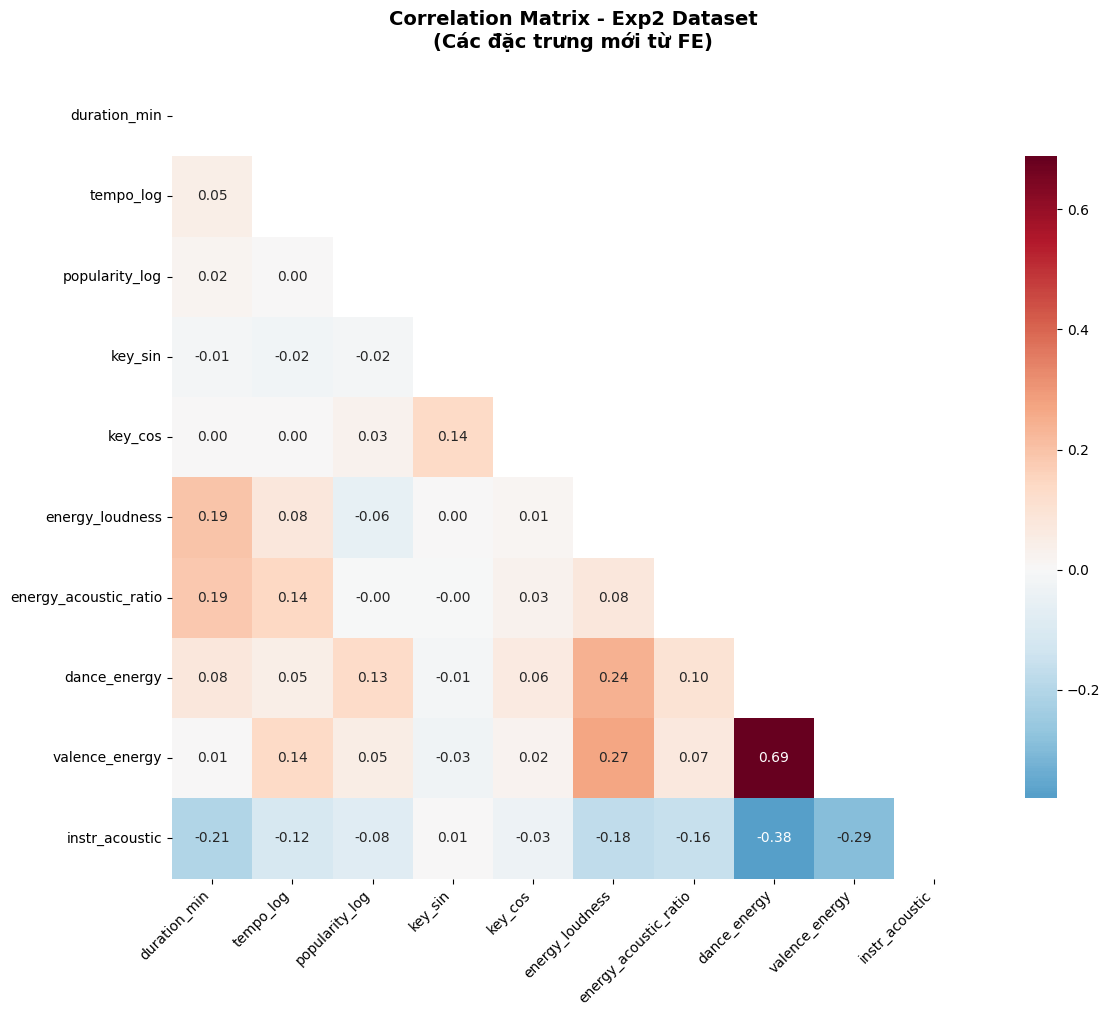

Các cặp đặc trưng có tương quan mạnh (|r| > 0.5):
  dance_energy vs valence_energy: 0.688


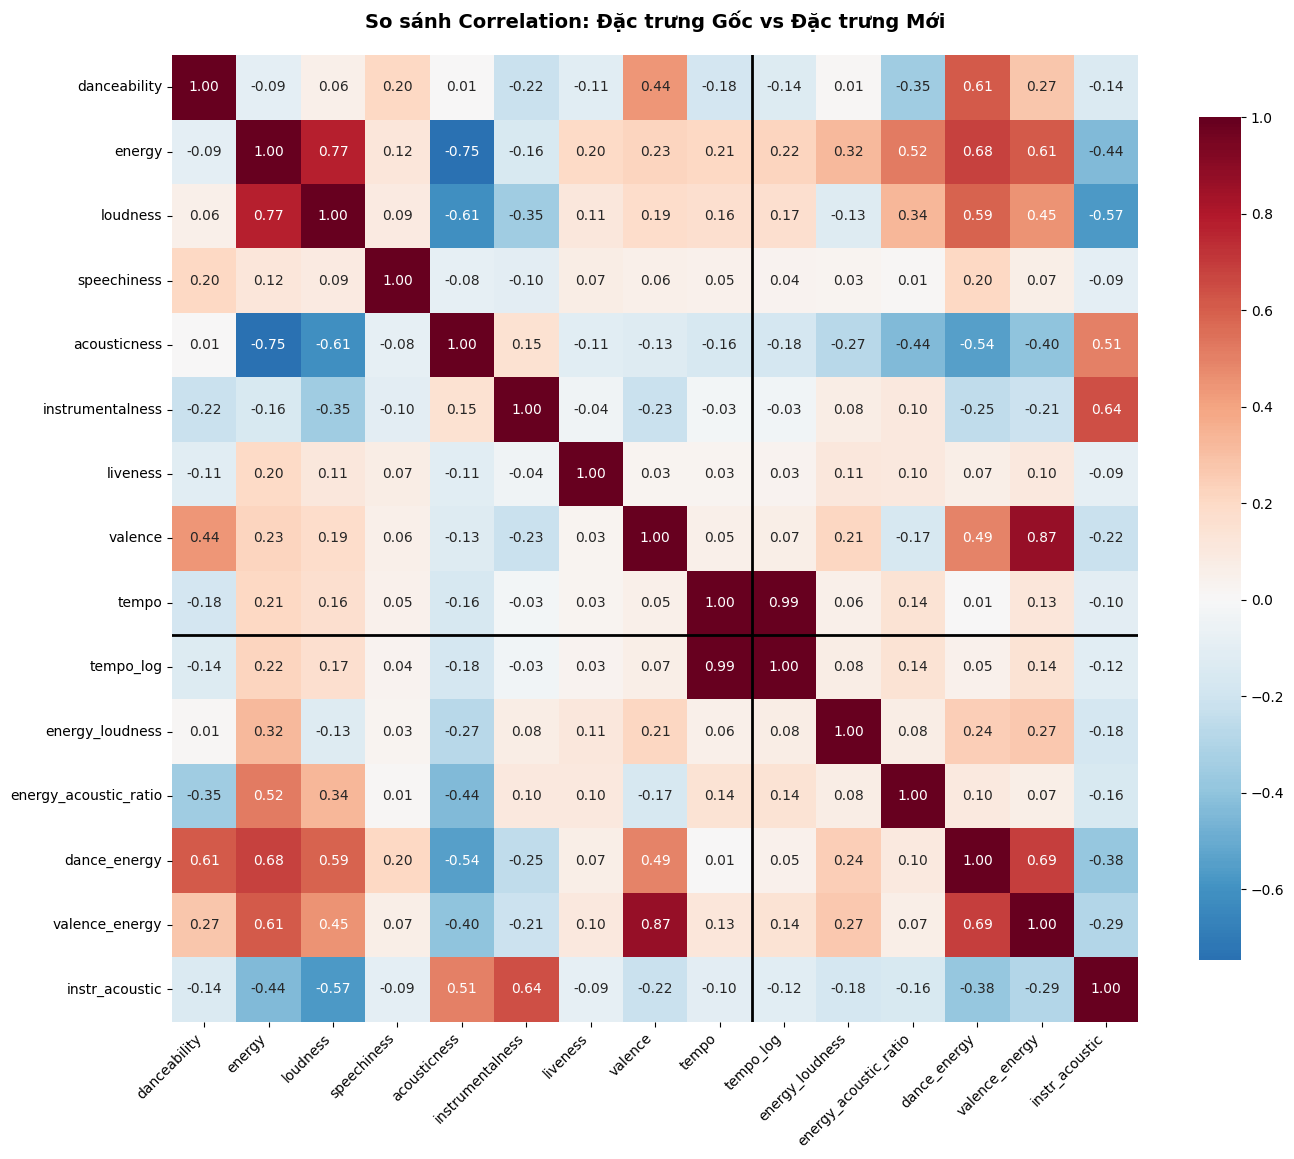

In [11]:
# Thêm cell mới để visualize mối quan hệ giữa các đặc trưng mới
import matplotlib.pyplot as plt
import seaborn as sns

def plot_new_features_correlation(train_df: pd.DataFrame, title: str):
    """
    Vẽ heatmap correlation cho các đặc trưng mới được tạo
    """
    # Danh sách các đặc trưng mới từ mục 3 và 4
    new_features = [
        # Từ mục 3
        'duration_min', 'tempo_log', 'popularity_log', 
        'key_sin', 'key_cos', 'energy_loudness',
        # Từ mục 4
        'energy_acoustic_ratio', 'dance_energy', 
        'valence_energy', 'instr_acoustic'
    ]
    
    # Lọc chỉ các đặc trưng mới có trong dataset
    available_features = [f for f in new_features if f in train_df.columns]
    
    if not available_features:
        print("Không tìm thấy đặc trưng mới trong dataset")
        return
    
    # Tính correlation matrix
    corr_matrix = train_df[available_features].corr()
    
    # Vẽ heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Ẩn nửa trên
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={'shrink': 0.8})
    
    plt.title(f'Correlation Matrix - {title}\n(Các đặc trưng mới từ FE)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # In ra các cặp tương quan mạnh (|correlation| > 0.5)
    print("Các cặp đặc trưng có tương quan mạnh (|r| > 0.5):")
    strong_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.5:
                strong_corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
    
    if strong_corr_pairs:
        for feat1, feat2, corr in sorted(strong_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {feat1} vs {feat2}: {corr:.3f}")
    else:
        print("  Không có cặp nào có |r| > 0.5")

# Áp dụng cho Exp2 dataset
print("=" * 60)
print("PHÂN TÍCH TƯƠNG QUAN GIỮA CÁC ĐẶC TRƯNG MỚI")
print("=" * 60)

plot_new_features_correlation(train_exp2, "Exp2 Dataset")

# So sánh với correlation của các đặc trưng gốc
def compare_original_vs_new_features(train_df: pd.DataFrame):
    """
    So sánh correlation giữa các đặc trưng gốc và đặc trưng mới
    """
    # Đặc trưng gốc cơ bản
    original_features = [
        'danceability', 'energy', 'loudness', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
    ]
    
    # Đặc trưng mới từ FE
    new_features = [
        'tempo_log', 'energy_loudness', 'energy_acoustic_ratio',
        'dance_energy', 'valence_energy', 'instr_acoustic'
    ]
    
    original_available = [f for f in original_features if f in train_df.columns]
    new_available = [f for f in new_features if f in train_df.columns]
    
    if original_available and new_available:
        # Tính correlation matrix cho cả gốc và mới
        all_features = original_available + new_available
        corr_matrix = train_df[all_features].corr()
        
        # Tách thành 4 phần: gốc-gốc, gốc-mới, mới-gốc, mới-mới
        n_original = len(original_available)
        
        plt.figure(figsize=(14, 12))
        sns.heatmap(corr_matrix, 
                    annot=True, 
                    cmap='RdBu_r', 
                    center=0,
                    square=True,
                    fmt='.2f',
                    cbar_kws={'shrink': 0.8})
        
        # Vẽ đường phân cách
        plt.axhline(y=n_original, color='black', linewidth=2)
        plt.axvline(x=n_original, color='black', linewidth=2)
        
        plt.title('So sánh Correlation: Đặc trưng Gốc vs Đặc trưng Mới', 
                  fontsize=14, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

# So sánh correlation
compare_original_vs_new_features(train_exp2)